# Vehicle Classifier #

Creating the Linear Support Vector Machine that will be used for vehicle detection

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from plot_images import *
from vehicle_features import *

## Preparing the Training Data ##

The training data features are in the following order (functions in vehicle_features.py):
1. HOG
2. Color binning
3. Color histogram

In [2]:
def getTrainingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

#Not Cars
nots = getTrainingImages('training_images/non-vehicles/Extras/*.png')
nots = nots+getTrainingImages('training_images/non-vehicles/GTI/*.png')
print("{} not-car training images".format(len(nots)))

#Cars
cars = getTrainingImages('training_images/vehicles/GTI_Far/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_Left/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_MiddleClose/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_Right/*.png')
cars = cars+getTrainingImages('training_images/vehicles/KITTI_extracted/*.png')
print("{} car training images".format(len(cars)))

8968 not-car training images
8792 car training images


In [3]:
# Parameters for feature extraction
color_space_in = 'RGB'
hog_orient = 9 
hog_pix_per_cell = 8 
hog_cells_per_block = 2 
spatial_size = (24, 24)
hist_bins = 40

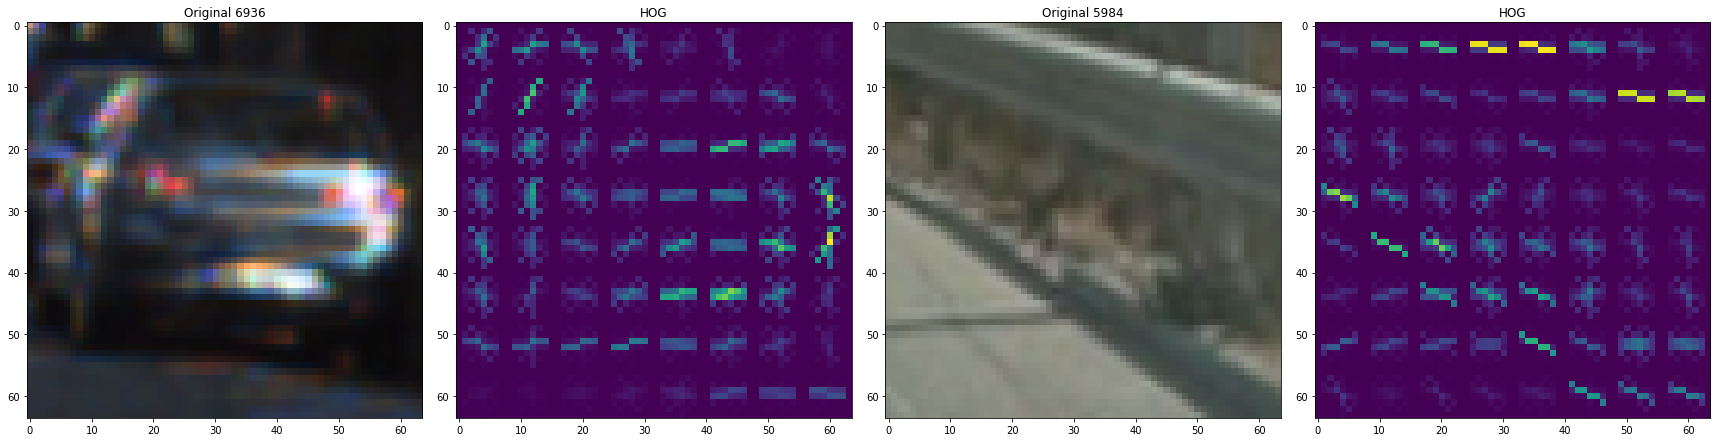

In [4]:
# Test extractions with visualization
car_idx = np.random.randint(0, len(cars))
not_idx = np.random.randint(0, len(nots))

car_features, car_hog = extractImgFeatures(cars[car_idx], color_space_in, hog_orient, 
                                           hog_pix_per_cell, hog_cells_per_block, 
                                           spatial_size, hist_bins, vis=True, hog_channel=0)
not_features, not_hog = extractImgFeatures(nots[not_idx], color_space_in, hog_orient, 
                                           hog_pix_per_cell, hog_cells_per_block, 
                                           spatial_size, hist_bins, vis=True, hog_channel=0)

plotMany(1,4, [cars[car_idx], car_hog, nots[not_idx], not_hog],
         ["Original {}".format(car_idx),'HOG',"Original {}".format(not_idx), 'HOG'], 
         [None,None,None,None])

In [5]:
#Extract the features
notcar_features = extractFeatures(nots, color_space_in, hog_orient, 
                                  hog_pix_per_cell, hog_cells_per_block, 
                                  spatial_size, hist_bins)
car_features = extractFeatures(cars, color_space_in, hog_orient, 
                               hog_pix_per_cell, hog_cells_per_block, 
                               spatial_size, hist_bins)

# Column scaling for X
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Y Labels (1 = car, 0 = notcar)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.1, 
                                                    random_state=rand_state)

## Training the SVC ##

In [6]:
svc = LinearSVC()

# training with a "stopwatch" running
t=time.time()
svc.fit(X_train, y_train)

print('Training classifier:')
print("\t* {} feature vectors".format(len(X_train[0])))
print("\t* Duration {:.4f} seconds".format(time.time()-t))
print("\t* Accuracy of {:.4f}".format(svc.score(X_test, y_test)))

Training classifier:
	* 7140 feature vectors
	* Duration 15.6215 seconds
	* Accuracy of 0.9814


## Detecting Vehicles ##

In [7]:
# Read in the testing images
def getTestingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

testImages = getTestingImages('test_images/test*.jpg')  
testTitles = []
testCmap = []
for i in range(0, len(testImages)):
    testTitles.append("Test #{}".format(i))
    testCmap.append(None)

In [8]:
def findCars(img, color_space_in, ystart, ystop, scale, svc, X_scaler,
             hog_orient, hog_pix_per_cell, hog_cells_per_block, 
             spatial_size, hist_bins):
    #Use the features to find cars in an image
    imgDisplay = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    bboxes = []
    # Adjust for .jpg vs the .png used for training
    img = img.astype(np.float32)/255
    
    imgRoi = convertColorSpace(img[ystart:ystop,:,:], color_space_in)
    if scale != 1:
        imshape = imgRoi.shape
        imgRoi = cv2.resize(imgRoi, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = imgRoi[:,:,0]
    ch2 = imgRoi[:,:,1]
    ch3 = imgRoi[:,:,2]

    # Define blocks and steps as above
    n_xBlocks = (ch1.shape[1] // hog_pix_per_cell) - hog_cells_per_block + 1
    n_yBlocks = (ch1.shape[0] // hog_pix_per_cell) - hog_cells_per_block + 1 
    n_features_per_block = hog_orient*hog_cells_per_block**2
    window = 64
    n_window_blocks = (window // hog_pix_per_cell) - hog_cells_per_block + 1
    n_cells_per_step = 2  # Instead of overlap, define how many cells to step
    n_xSteps = (n_xBlocks - n_window_blocks) // n_cells_per_step
    n_ySteps = (n_yBlocks - n_window_blocks) // n_cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = extractHog(ch1, hog_orient, hog_pix_per_cell, hog_cells_per_block, 
                      vis=False, feature_vec=False)
    hog2 = extractHog(ch2, hog_orient, hog_pix_per_cell, hog_cells_per_block, 
                      vis=False, feature_vec=False)
    hog3 = extractHog(ch3, hog_orient, hog_pix_per_cell, hog_cells_per_block, 
                      vis=False, feature_vec=False)
    
    for xb in range(n_xSteps):
        for yb in range(n_ySteps):
            ypos = yb*n_cells_per_step
            xpos = xb*n_cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+n_window_blocks, xpos:xpos+n_window_blocks].ravel() 
            hog_feat2 = hog2[ypos:ypos+n_window_blocks, xpos:xpos+n_window_blocks].ravel() 
            hog_feat3 = hog3[ypos:ypos+n_window_blocks, xpos:xpos+n_window_blocks].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*hog_pix_per_cell
            ytop = ypos*hog_pix_per_cell

            # Extract the image patch
            imgSub = cv2.resize(imgRoi[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = binColorsSpatially(imgSub, spatial_size)
            hist_features = computeColorHistogram(imgSub, hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(
                (hog_features, spatial_features, hist_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ybox_top = np.int(ytop*scale)+ystart
                frame = np.int(window*scale)
                
                box_top_left = (xbox_left, ybox_top)
                box_bottom_right = (xbox_left+frame, ybox_top+frame)
                
                cv2.rectangle(imgDisplay, box_top_left, box_bottom_right,(0,0,255),6) 
                heatmap[ybox_top:ybox_top+frame,xbox_left:xbox_left+frame] += 1
                bboxes.append((box_top_left, box_bottom_right))
                
    return imgDisplay, heatmap, bboxes

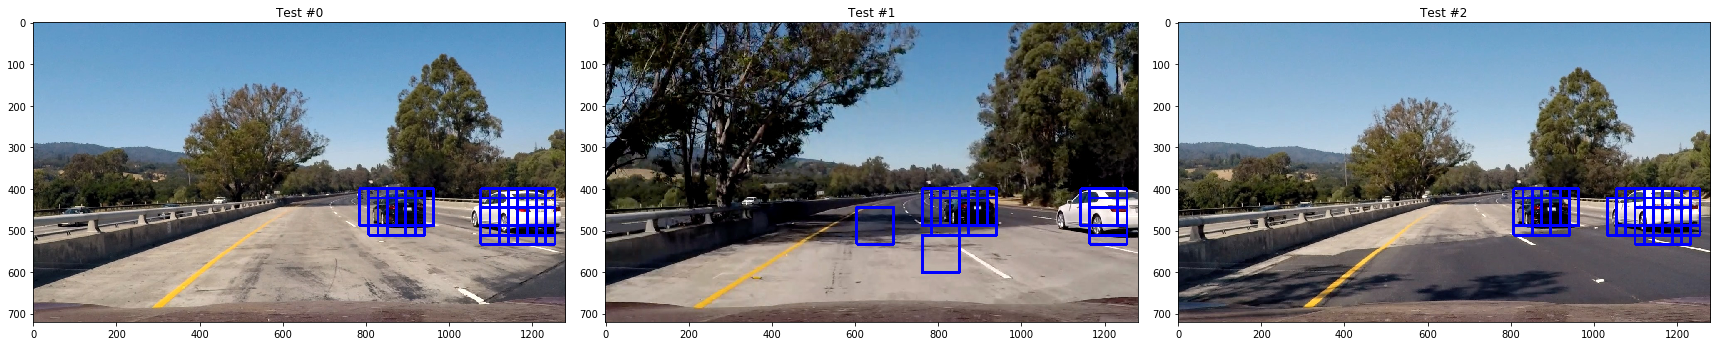

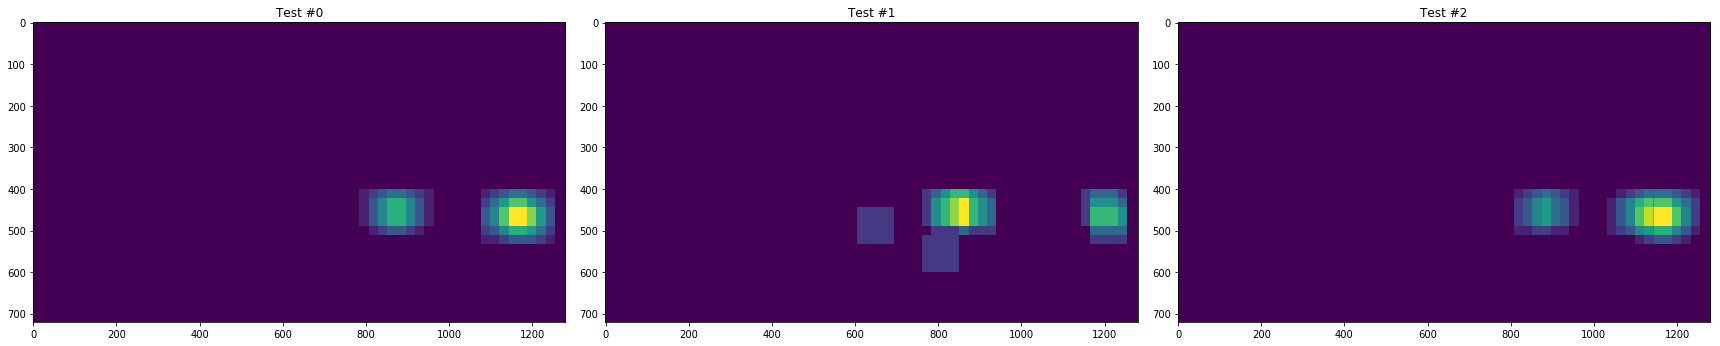

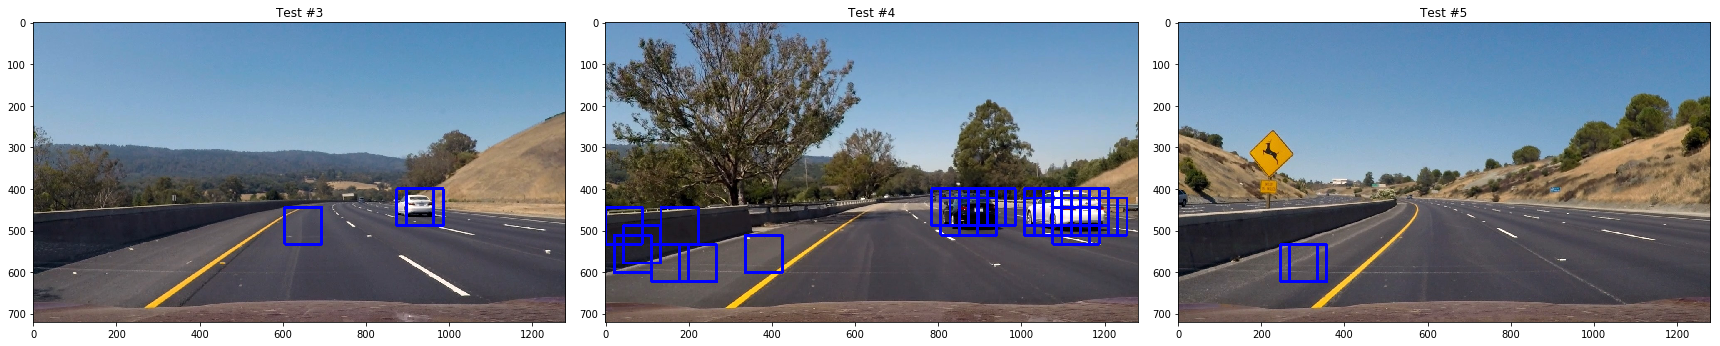

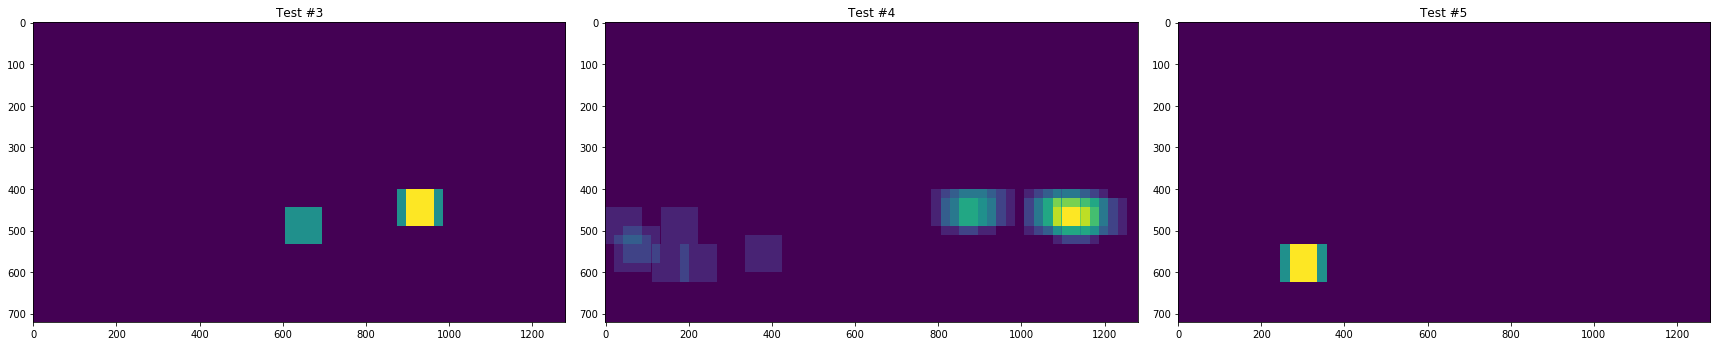

In [9]:
testResults = []
testHeatmaps = []
testBBoxes = []
ystart = 400
ystop = 650
scale = 1.4

for img in testImages:
    result, heatmap, bboxes = findCars(img, color_space_in, ystart, ystop, scale, svc, X_scaler,
                               hog_orient, hog_pix_per_cell, hog_cells_per_block, 
                               spatial_size, hist_bins)
    testResults.append(result)
    testHeatmaps.append(heatmap)
    testBBoxes.append(bboxes)

plotMany(1,3, testResults[0:3], testTitles[0:3], testCmap[0:3])
plotMany(1,3, testHeatmaps[0:3], testTitles[0:3], testCmap[0:3])
plotMany(1,3, testResults[3:6], testTitles[3:6], testCmap[3:6])
plotMany(1,3, testHeatmaps[3:6], testTitles[3:6], testCmap[3:6])

In [10]:
def addHeat(heatmap, bboxes):
    for bbox in bboxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def thresholdHeatmap(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def drawBoundingBoxes(img, heatmap, threshold):
    heatmap = thresholdHeatmap(heatmap, threshold)
    labels = label(heatmap)
    for car_label in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_label).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

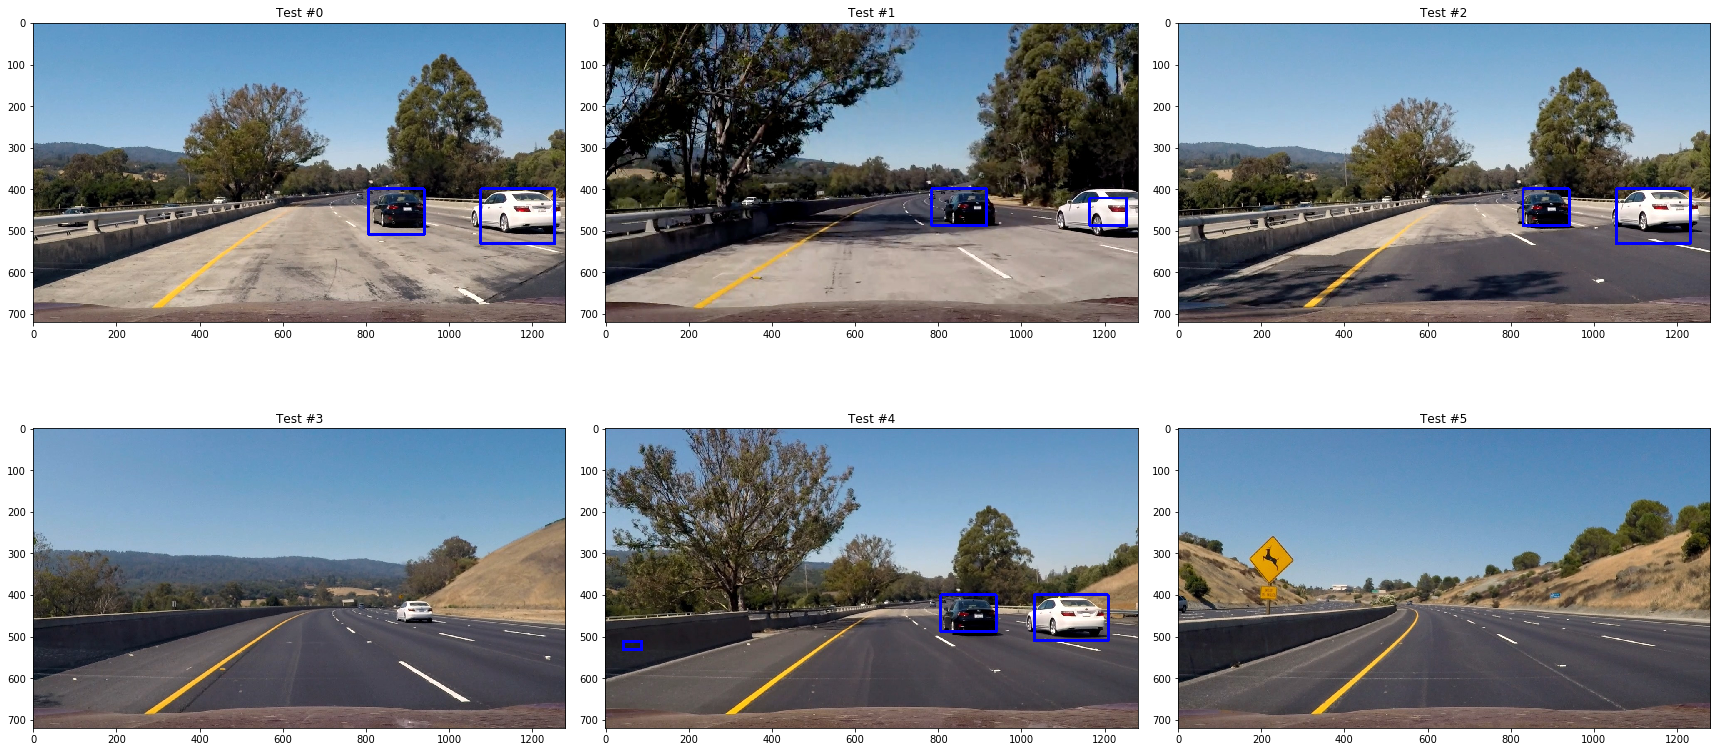

In [11]:
testResults = []
ystart = 400
ystop = 650
scale = 1.4
threshold = 2

for img in testImages:
    result, heatmap, bboxes = findCars(img, color_space_in, ystart, ystop, scale, svc, 
                                       X_scaler, hog_orient, hog_pix_per_cell, 
                                       hog_cells_per_block, spatial_size, hist_bins)
    boundResult = drawBoundingBoxes(np.copy(img), heatmap, threshold)
    testResults.append(boundResult)


plotMany(2,3, testResults, testTitles, testCmap)

In [ ]:
class TrackVehicles():
    def __init__(self, printDebug=False):
        self.init = False
        self.bboxes = []
        self.heatmap = []
        #Variable to display for testing
        self.printDebug = printDebug
        return
    
    def initialize(self, img):
        self.heatmap = np.zeros_like(img[:,:,0])
        self.init = True
        return
    
    def reset(self):
        self.init = False
        self.bboxes = []
        return
    
    def update(img):
        if not self.init:
            self.initialize(img)
        